#Implementation of **TokenCut for Instance Segmentation**

In [4]:
!pip install -U tensorflow-addons
!pip install --quiet vit-keras
!pip install cython
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
!pip install Pillow
!pip install matplotlib
!pip install opencv-python
!pip install scikit-learn
!pip install scikit-image


[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /private/var/folders/lj/zjyrc97j1c7f_qyxhdkl_0vr0000gn/T/pip-req-build-eiypk_f5
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /private/var/folders/lj/zjyrc97j1c7f_qyxhdkl_0vr0000gn/T/pip-req-build-eiypk_f5
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 0d53acbcf5123d4c88040fe68fbb9805fc5b2fb9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[not


[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [5]:
import pandas as pd
import numpy as np
import scipy
import PIL.Image as Image
import tensorflow as tf
from keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from vit_keras import vit
import math,sys, os, random, glob, cv2
from sklearn.metrics.pairwise import cosine_similarity
from scipy import ndimage 
import matplotlib.image as mpimg
import pydensecrf.densecrf as dcrf
import pydensecrf.utils as utils
import cv2
import PIL
import random
from skimage import io
import requests
from io import BytesIO

###Visual Transmormer Model

In [6]:
vit_model = vit.vit_b16(
        image_size = 16,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 0)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 1, 1
  warnings.warn(


Dividing the image into patches to get the **Features** of each patch from the VIT

In [7]:
def get_patches(patch_size,images):
  batch_size = tf.shape(images)[0]
  patches = tf.image.extract_patches(
      images=images,
      sizes=[1, patch_size, patch_size, 1],
      strides=[1, patch_size, patch_size, 1],
      rates=[1, 1, 1, 1],
      padding="VALID",
  )
  patch_dims = patches.shape[-1]
  patches = tf.reshape(patches, [batch_size, -1, patch_dims])
  return patches

In [8]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In the implementation image size **960 is taken instead of 480** as in the research paper. And patch size **16 is taken instead of 8**.

In [9]:
image_size=960
patch_size=16

In [10]:
def check_num_fg_corners(affinity_matrix):
  n=affinity_matrix.shape[0]-1
  m=affinity_matrix.shape[1]-1
  r_t=affinity_matrix[0,m]
  r_b=affinity_matrix[n,m]
  l_t=affinity_matrix[0,0]
  l_b=affinity_matrix[n,0]

  return int(r_t) +int(r_b)+int(l_b)+int(l_t)

In [11]:
def IoU(A,B):
  eps=1e-12
  intersection=A*B
  union=A+B
  return (np.sum(intersection)+eps)/(np.sum(union)+eps)

####Function to solve following equation:
  $(D-W)x = λD$<br>
to get second smallest eigen value λ<br><br>
where,<br>
W is a $N \times N$ Matrix with $W_{ij}=\frac{K_iK_j}{||K_i||_2||K_j||_2}$,<br>
D is a $N \times N$ diagonal matrix with $d(i)=\sum\limits_jW_{ij}$,<br>
and x is the eigen vector corresponding to second smallest eigen value λ




In [12]:
def get_second_smallest_eigen_vector(features,TouNcut,epsilon):
  W=cosine_similarity(features.T, features.T)
  W[W<=TouNcut]=epsilon
  W[W>TouNcut]=1
  d_i=np.sum(np.array(W),axis=1)
  D=np.diag(d_i)
  eigen_values,eigen_vectors=scipy.linalg.eigh(D-W,D, subset_by_index=[1,2])
  return eigen_vectors[:,0]

In [13]:
def vis_mask(input, mask, mask_color) :
    fg = mask > 0.5
    rgb = np.copy(input)
    rgb[fg] = (rgb[fg] * 0.3 + np.array(mask_color) * 0.7).astype(np.uint8)
    return Image.fromarray(rgb)

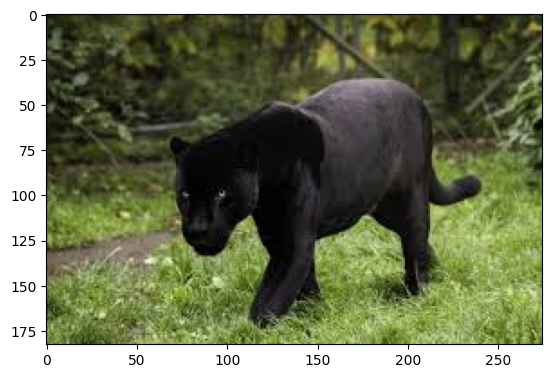

In [18]:
img_path='https://raw.githubusercontent.com/saurav188/Object_Detection/main/demo_images/demo2.jpeg' 

img = io.imread(img_path)
#img = mpimg.imread(img_path)

imgplot = plt.imshow(img)
plt.show()

resized_image = tf.image.resize(
    tf.convert_to_tensor([img]), size=(image_size, image_size)
)

#for detector
response = requests.get(img_path)
I = Image.open(BytesIO(response.content)).convert('RGB')
I_new = I.resize((image_size, image_size), PIL.Image.LANCZOS)

patches=get_patches(patch_size,resized_image)

pre_proccessed_patches=[]
for i,patch in enumerate(patches[0]):
  pre_proccessed_patches.append(patch.numpy().reshape((patch_size, patch_size,3)))


In [20]:
TouNcut=0.21
epsilon=1e-5

#getting output/features form ViT
features=vit_model.predict(np.array(pre_proccessed_patches)).T

dims=(int(math.sqrt(features.shape[1])),int(math.sqrt(features.shape[1])))
#num_patches,dim = features.shape[0], features.shape[1]

second_smallest_eigen_vector=get_second_smallest_eigen_vector(features,TouNcut,epsilon)
y_mean=second_smallest_eigen_vector.sum()/second_smallest_eigen_vector.shape[0]
bipartition=second_smallest_eigen_vector>y_mean

# check if we should reverse the partition based on:
# 1) peak of the 2nd smallest eigvec 
# 2) object centric bias i.e if 3 or more corners are in bipartition reverse
seed = np.argmax(np.abs(second_smallest_eigen_vector))
nc = check_num_fg_corners(np.reshape(bipartition,dims))
reverse=False
if nc >= 3:
  reverse = True
else:
  reverse = bipartition[seed] != 1

if reverse:
# reverse bipartition, eigenvector and get new seed
      eigenvec = second_smallest_eigen_vector * -1
      bipartition = np.logical_not(bipartition)
      seed = np.argmax(eigenvec)
else:
      seed = np.argmax(second_smallest_eigen_vector)
affinity_matrix=np.reshape(bipartition,dims).astype(float)


objects, num_objects = ndimage.label(affinity_matrix)
cc = objects[np.unravel_index(seed, dims)]
temp = np.where(objects == cc)
pseudo_mask = np.zeros(dims,dtype=float)
pseudo_mask[temp[0],temp[1]] = 1.
ps=pseudo_mask.shape[0]

pseudo_mask=np.repeat(np.repeat(pseudo_mask,patch_size,axis=0),patch_size,axis=1)
pseudo_mask2 = ndimage.binary_fill_holes(pseudo_mask>=0.5)
  
# filter out the mask that have a very different pseudo-mask after the CRF
if IoU(pseudo_mask, pseudo_mask2) < 0.:
    pseudo_mask2 = pseudo_mask2 * -1
  
# construct binary pseudo-masks
mask=pseudo_mask2
mask[mask < 0] = 0.
mask = np.uint8(mask*255)

mask = mask.astype(np.uint8)
upper = np.max(mask)
lower = np.min(mask)
thresh = upper / 2.0
mask[mask > thresh] = upper
mask[mask <= thresh] = lower

113/113 [==============================] - 16s 141ms/step


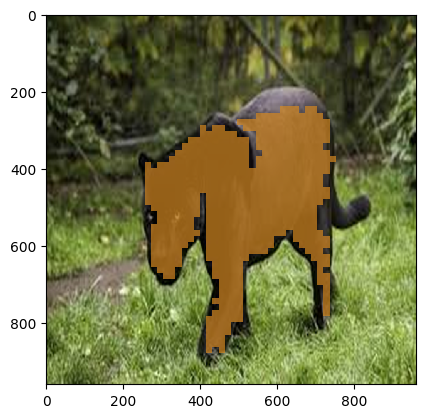

In [21]:
input = np.array(I_new)
input = vis_mask(input, mask, (random.randint(0,256),random.randint(0,256),random.randint(0,256)))

plt.imshow(input, cmap='hot', interpolation='nearest')
plt.show()